In [437]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np

N = 10000
input_dims = 500
seed = 1234
pos_ratio = 0.5

X, y = make_classification(n_samples=N, 
                           n_features=n_features, 
                           random_state=seed, 
                           weights=[1 - pos_ratio, pos_ratio])

In [438]:
# 訓練データと評価データに分類
train_x_np, valid_x_np, train_y_np, valid_y_np = train_test_split(X, y, test_size=0.1, random_state=seed)
print("train:", train_y_np.shape[0])
print("train pos ratio: {:.2f}".format(float(train_y_np[train_y_np == 1].shape[0]) / train_y_np.shape[0]))
print("valid:", valid_y_np.shape[0])
print("valid pos ratio: {:.2f}".format(float(valid_y_np[valid_y_np == 1].shape[0]) / valid_y_np.shape[0]))

train: 9000
train pos ratio: 0.50
valid: 1000
valid pos ratio: 0.49


## 分類器の作成

In [439]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

# データセットを作成
train_batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x_np).float(), torch.from_numpy(train_y_np.astype(np.int64)))
train_iter = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)  # the data reshuffled at every epoch 
valid_batch_size = 64
valid_data = TensorDataset(torch.from_numpy(valid_x_np).float(), torch.from_numpy(valid_y_np.astype(np.int64)))
valid_iter = DataLoader(valid_data, batch_size=valid_batch_size)

In [440]:
class MLP(nn.Module):
    
    def __init__(self, input_dims, hidden_dims, num_classes, dropout):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dims, hidden_dims)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dims, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [441]:
# model instance の作成
hidden_dims = 200
num_classes = 2
dropout = 0.5
model = MLP(input_dims, hidden_dims, num_classes, dropout)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.01)

In [442]:
def train(train_iter):
    loss = 0
    correct = 0
    
    model.train()
    for i, (train_x, train_y) in enumerate(train_iter):
        optimizer.zero_grad()
        outputs = model(train_x)
        loss_ = F.cross_entropy(outputs, train_y)
        loss_.backward()
        optimizer.step()
        correct_ = (torch.max(outputs, 1)[1].view(train_y.size()).data == train_y.data).sum()
        correct += correct_
        loss += loss_.item()
    return correct, loss / len(train_iter)

def valid(valid_iter):
    loss = 0
    correct = 0

    model.eval()
    for i, (valid_x, valid_y) in enumerate(valid_iter):
        outputs = model(valid_x)
        loss_ = F.cross_entropy(outputs, valid_y)
        loss += loss_.item()
        correct_ = (torch.max(outputs, 1)[1].view(valid_y.size()).data == valid_y.data).sum()
        correct += correct_
    return correct, loss / len(valid_iter)

In [443]:
# 学習前の予測精度
train_size = train_x_np.shape[0]
corrects = 0
for i, (train_x, train_y) in enumerate(train_iter):
    outputs = model(train_x)
    correct = (torch.max(outputs, 1)[1].view(train_y.size()).data == train_y.data).sum()
    corrects += correct
print('acc: {:.4f}'.format(float(corrects) / train_size))

acc: 0.5129


In [446]:
epochs = 50
train_size = train_x_np.shape[0]
valid_size = valid_x_np.shape[0]

loss_list = []
valid_loss_list = []
acc_list = []
valid_acc_list = []

for epoch in range(1, epochs + 1):
    correct, loss = train(train_iter)
    loss_list.append(loss)
    acc_list.append(float(correct) / train_size)
    val_correct, val_loss = valid(valid_iter)
    valid_loss_list.append(val_loss)
    valid_acc_list.append(float(val_correct) / valid_size)
    print('epoch:{} loss: {:.4f} val_loss: {:.4f} acc: {:.4f} val acc: {:.4f}'.format(
        epoch, loss, val_loss, float(correct) / train_size, float(val_correct) / valid_size))

epoch:1 loss: 0.3210 val_loss: 0.3284 acc: 0.8809 val acc: 0.8840
epoch:2 loss: 0.3199 val_loss: 0.3265 acc: 0.8781 val acc: 0.8840
epoch:3 loss: 0.3153 val_loss: 0.3248 acc: 0.8840 val acc: 0.8840
epoch:4 loss: 0.3169 val_loss: 0.3231 acc: 0.8792 val acc: 0.8850
epoch:5 loss: 0.3139 val_loss: 0.3215 acc: 0.8808 val acc: 0.8850
epoch:6 loss: 0.3104 val_loss: 0.3201 acc: 0.8826 val acc: 0.8840
epoch:7 loss: 0.3076 val_loss: 0.3187 acc: 0.8827 val acc: 0.8830
epoch:8 loss: 0.3059 val_loss: 0.3173 acc: 0.8867 val acc: 0.8830
epoch:9 loss: 0.3014 val_loss: 0.3160 acc: 0.8891 val acc: 0.8840
epoch:10 loss: 0.2997 val_loss: 0.3148 acc: 0.8867 val acc: 0.8850
epoch:11 loss: 0.2965 val_loss: 0.3135 acc: 0.8914 val acc: 0.8840
epoch:12 loss: 0.3004 val_loss: 0.3125 acc: 0.8859 val acc: 0.8850
epoch:13 loss: 0.2977 val_loss: 0.3115 acc: 0.8883 val acc: 0.8850
epoch:14 loss: 0.2989 val_loss: 0.3105 acc: 0.8843 val acc: 0.8850
epoch:15 loss: 0.2940 val_loss: 0.3095 acc: 0.8880 val acc: 0.8840
epoc

In [447]:
def predict(model, test_x):
    model.eval()
    outputs = model(test_x)
    return torch.max(outputs, 1)[1]

In [448]:
# metrics
test_x = torch.from_numpy(valid_x_np).float()
pred = predict(model, test_x)

tn, fp, fn, tp = confusion_matrix(valid_y_np, pred.numpy()).ravel()

precision = float(tp) / (tp + fp)
recall = float(tp) / (tp + fn)

print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F-measure: {:.3f}".format((2 * recall * precision) / (recall + precision)))

Precision: 0.896
Recall: 0.858
F-measure: 0.876


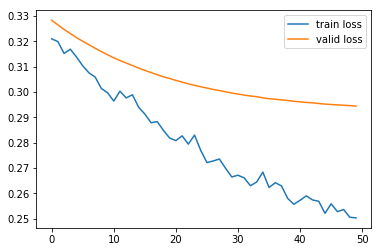

In [449]:
import matplotlib.pyplot as plt
plt.plot(range(epochs),loss_list, label="train loss")
plt.plot(range(epochs),valid_loss_list, label="valid loss")
plt.legend()
plt.show()

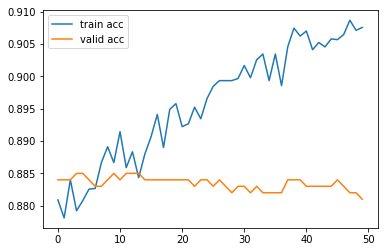

In [450]:
plt.plot(range(epochs),acc_list, label="train acc")
plt.plot(range(epochs),valid_acc_list, label="valid acc")
plt.legend()
plt.show()

## 不均衡データで検証

In [451]:
N = 10000
input_dims = 500
seed = 1234
pos_ratio = 0.1

X, y = make_classification(n_samples=N, 
                           n_features=n_features, 
                           random_state=seed, 
                           weights=[1 - pos_ratio, pos_ratio])

In [452]:
# 訓練データと評価データに分類
train_x_np, valid_x_np, train_y_np, valid_y_np = train_test_split(X, y, test_size=0.1, random_state=seed)
print("train:", train_y_np.shape[0])
print("train pos ratio: {:.2f}".format(float(train_y_np[train_y_np == 1].shape[0]) / train_y_np.shape[0]))
print("valid:", valid_y_np.shape[0])
print("valid pos ratio: {:.2f}".format(float(valid_y_np[valid_y_np == 1].shape[0]) / valid_y_np.shape[0]))

# データセットを作成
train_batch_size = 64
train_data = TensorDataset(torch.from_numpy(train_x_np).float(), torch.from_numpy(train_y_np.astype(np.int64)))
train_iter = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)  # the data reshuffled at every epoch 
valid_batch_size = 64
valid_data = TensorDataset(torch.from_numpy(valid_x_np).float(), torch.from_numpy(valid_y_np.astype(np.int64)))
valid_iter = DataLoader(valid_data, batch_size=valid_batch_size)

train: 9000
train pos ratio: 0.10
valid: 1000
valid pos ratio: 0.11


In [453]:
model = MLP(input_dims, hidden_dims, num_classes, dropout)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.01)

In [454]:
epochs = 50
train_size = train_x_np.shape[0]
valid_size = valid_x_np.shape[0]

loss_list = []
valid_loss_list = []
acc_list = []
valid_acc_list = []

for epoch in range(1, epochs + 1):
    correct, loss = train(train_iter)
    loss_list.append(loss)
    acc_list.append(float(correct) / train_size)
    val_correct, val_loss = valid(valid_iter)
    valid_loss_list.append(val_loss)
    valid_acc_list.append(float(val_correct) / valid_size)
    print('epoch:{} loss: {:.4f} val_loss: {:.4f} acc: {:.4f} val acc: {:.4f}'.format(
        epoch, loss, val_loss, float(correct) / train_size, float(val_correct) / valid_size))

epoch:1 loss: 0.6079 val_loss: 0.4637 acc: 0.6789 val acc: 0.8880
epoch:2 loss: 0.4168 val_loss: 0.3788 acc: 0.8907 val acc: 0.8910
epoch:3 loss: 0.3636 val_loss: 0.3517 acc: 0.8953 val acc: 0.8910
epoch:4 loss: 0.3454 val_loss: 0.3405 acc: 0.8954 val acc: 0.8910
epoch:5 loss: 0.3383 val_loss: 0.3347 acc: 0.8954 val acc: 0.8910
epoch:6 loss: 0.3295 val_loss: 0.3311 acc: 0.8956 val acc: 0.8910
epoch:7 loss: 0.3265 val_loss: 0.3284 acc: 0.8954 val acc: 0.8910
epoch:8 loss: 0.3237 val_loss: 0.3260 acc: 0.8954 val acc: 0.8910
epoch:9 loss: 0.3210 val_loss: 0.3239 acc: 0.8954 val acc: 0.8910
epoch:10 loss: 0.3165 val_loss: 0.3219 acc: 0.8954 val acc: 0.8910
epoch:11 loss: 0.3144 val_loss: 0.3201 acc: 0.8954 val acc: 0.8910
epoch:12 loss: 0.3114 val_loss: 0.3182 acc: 0.8954 val acc: 0.8910
epoch:13 loss: 0.3110 val_loss: 0.3163 acc: 0.8954 val acc: 0.8910
epoch:14 loss: 0.3086 val_loss: 0.3145 acc: 0.8954 val acc: 0.8910
epoch:15 loss: 0.3051 val_loss: 0.3126 acc: 0.8954 val acc: 0.8910
epoc

In [456]:
# metrics
test_x = torch.from_numpy(valid_x_np).float()
pred = predict(model, test_x)

tn, fp, fn, tp = confusion_matrix(valid_y_np, pred.numpy()).ravel()

precision = float(tp) / (tp + fp)
recall = float(tp) / (tp + fn)

print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F-measure: {:.3f}".format((2 * recall * precision) / (recall + precision)))

print("{0} positive samples in prediction".format(torch.sum((pred == 1).int()).item()))

Precision: 1.000
Recall: 0.018
F-measure: 0.036
2 positive samples in prediction


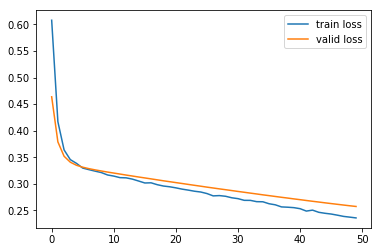

In [457]:
plt.plot(range(epochs),loss_list, label="train loss")
plt.plot(range(epochs),valid_loss_list, label="valid loss")
plt.legend()
plt.show()

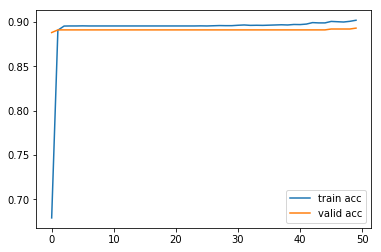

In [458]:
plt.plot(range(epochs),acc_list, label="train acc")
plt.plot(range(epochs),valid_acc_list, label="valid acc")
plt.legend()
plt.show()

## CNN with bootstrapping method
---
https://users.cs.fiu.edu/~chens/PDF/ISM15.pdf

In [459]:
# divide train data into negative and positive classes
neg_train_x_np = train_x_np[train_y_np == 0]
neg_train_y_np = train_y_np[train_y_np == 0]
pos_train_x_np = train_x_np[train_y_np == 1]
pos_train_y_np = train_y_np[train_y_np == 1]
print("negative train size: ", neg_train_y_np.shape[0])
print("positive train size: ", pos_train_y_np.shape[0])
print("positive ratio: {:.2f}".format(float(pos_train_y_np.shape[0]) / train_y_np.shape[0]))

neg_train_data = TensorDataset(torch.from_numpy(neg_train_x_np).float(), torch.from_numpy(neg_train_y_np.astype(np.int64)))
neg_train_iter = DataLoader(neg_train_data, batch_size=int(train_batch_size / 2), shuffle=True)  # the data reshuffled at every epoch 

negative train size:  8059
positive train size:  941
positive ratio: 0.10


In [460]:
def train(pn_train):
    model.train()
    
    for train_x, train_y in pn_train:
        optimizer.zero_grad()
        outputs = model(train_x)
        loss = F.cross_entropy(outputs, train_y)
        loss.backward()
        optimizer.step()
        correct = (torch.max(outputs, 1)[1].view(train_y.size()).data == train_y.data).sum()
    return correct, loss.item()   

In [461]:
def data_shuffle(X, y):
    for l in [X, y]:
        np.random.shuffle(l)

In [462]:
# model initialize
model = MLP(input_dims, hidden_dims, num_classes, dropout)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.01)

epochs = 50
train_size = 0
valid_size = valid_x_np.shape[0]

loss_list = []
valid_loss_list = []
acc_list = []
valid_acc_list = []

for epoch in range(1, epochs + 1):
    correct = 0
    loss = 0
    train_size = 0
    for i, (neg_train_x, neg_train_y) in enumerate(neg_train_iter):
        neg_size = neg_train_x.size()[0]
        data_shuffle(pos_train_x_np, pos_train_y_np)
        # random sampling from postive dataset
        pos_train_x = torch.from_numpy(pos_train_x_np[:neg_size, :]).float()
        pos_train_y = torch.from_numpy(pos_train_y_np[:neg_size].astype(np.int64))
        # combine the positive and negative instances together
        pn_train_x = torch.cat((neg_train_x, pos_train_x), 0)
        pn_train_y = torch.cat((neg_train_y, pos_train_y), 0)
        train_size += pn_train_x.size()[0]
        pn_train = DataLoader(TensorDataset(pn_train_x, pn_train_y), batch_size = train_batch_size, shuffle=True) 
        correct_, loss_ = train(pn_train)
        correct += correct_
        loss += loss_ / len(neg_train_iter)
    loss_list.append(loss)
    acc_list.append(float(correct) / train_size)
    val_correct, val_loss = valid(valid_iter)
    valid_loss_list.append(val_loss)
    valid_acc_list.append(float(val_correct) / valid_size)
    print('epoch:{} loss: {:.4f} val_loss: {:.4f} acc: {:.4f} val acc: {:.4f}'.format(
        epoch, loss, val_loss, float(correct) / train_size, float(val_correct) / valid_size))

epoch:1 loss: 0.7032 val_loss: 0.6679 acc: 0.5272 val acc: 0.6140
epoch:2 loss: 0.6759 val_loss: 0.6511 acc: 0.5731 val acc: 0.6630
epoch:3 loss: 0.6517 val_loss: 0.6319 acc: 0.6202 val acc: 0.7120
epoch:4 loss: 0.6292 val_loss: 0.6094 acc: 0.6594 val acc: 0.7540
epoch:5 loss: 0.6068 val_loss: 0.5894 acc: 0.6952 val acc: 0.7810
epoch:6 loss: 0.5883 val_loss: 0.5718 acc: 0.7215 val acc: 0.8020
epoch:7 loss: 0.5661 val_loss: 0.5478 acc: 0.7453 val acc: 0.8210
epoch:8 loss: 0.5460 val_loss: 0.5280 acc: 0.7668 val acc: 0.8390
epoch:9 loss: 0.5269 val_loss: 0.5075 acc: 0.7832 val acc: 0.8520
epoch:10 loss: 0.5055 val_loss: 0.4891 acc: 0.7975 val acc: 0.8570
epoch:11 loss: 0.4888 val_loss: 0.4715 acc: 0.8080 val acc: 0.8680
epoch:12 loss: 0.4683 val_loss: 0.4539 acc: 0.8238 val acc: 0.8730
epoch:13 loss: 0.4500 val_loss: 0.4373 acc: 0.8314 val acc: 0.8770
epoch:14 loss: 0.4356 val_loss: 0.4239 acc: 0.8397 val acc: 0.8830
epoch:15 loss: 0.4194 val_loss: 0.4090 acc: 0.8482 val acc: 0.8860
epoc

In [463]:
test_x = torch.from_numpy(valid_x_np).float()
pred = predict(model, test_x)

tn, fp, fn, tp = confusion_matrix(valid_y_np, pred.numpy()).ravel()

precision = float(tp) / (tp + fp)
recall = float(tp) / (tp + fn)

print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F-measure: {:.3f}".format((2 * recall * precision) / (recall + precision)))

print("{0} positive samples in prediction".format(torch.sum((pred == 1).int()).item()))
print("{0} positive samples in ground truth".format(len(valid_y_np[valid_y_np == 1])))

Precision: 0.576
Recall: 0.761
F-measure: 0.656
144 positive samples in prediction
109 positive samples in ground truth


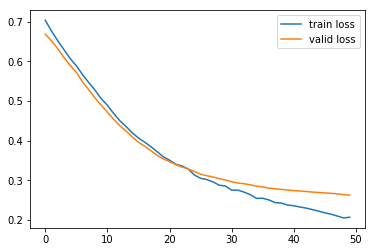

In [464]:
plt.plot(range(epochs),loss_list, label="train loss")
plt.plot(range(epochs),valid_loss_list, label="valid loss")
plt.legend()
plt.show()

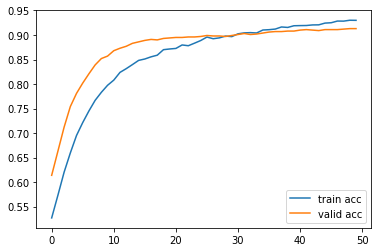

In [465]:
plt.plot(range(epochs),acc_list, label="train acc")
plt.plot(range(epochs),valid_acc_list, label="valid acc")
plt.legend()
plt.show()